In [1]:
#基于单个输入特征预测各城市街区的房屋价值中位数，在 TensorFlow 中使用 LinearRegressor 类

In [2]:
from __future__ import print_function

import math

from IPython import display
#import color map
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
#加载数据集
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

In [4]:
#数据进行随机化处理，以确保不会出现任何病态排序结果（可能会损害随机梯度下降法的效果）
#将 median_house_value 调整为以千为单位，模型能以常用范围内的学习速率较为轻松地学习这些数据
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
862,-117.1,34.1,34.0,45.0,11.0,39.0,14.0,3.1,500.0
147,-116.2,33.7,25.0,2888.0,654.0,2940.0,660.0,2.2,66.7
15212,-122.3,37.9,47.0,2077.0,400.0,719.0,326.0,2.2,172.7
807,-117.1,33.1,31.0,2055.0,473.0,1326.0,427.0,3.1,139.9
15113,-122.3,38.0,14.0,2338.0,391.0,1003.0,398.0,4.2,170.5
...,...,...,...,...,...,...,...,...,...
5714,-118.2,34.1,38.0,1158.0,309.0,1051.0,322.0,2.3,169.3
6341,-118.3,34.5,6.0,5813.0,908.0,2275.0,790.0,4.8,340.4
14553,-122.2,37.4,47.0,2600.0,490.0,1149.0,465.0,5.0,476.3
5615,-118.2,34.1,44.0,1688.0,426.0,1605.0,384.0,3.4,184.9


In [5]:
#检查数据
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [6]:
#配置一个特征，目标/标签，
#使用numeric_column 定义特征列
my_feature = california_housing_dataframe[["total_rooms"]]
targets = california_housing_dataframe["median_house_value"]
feature_columns = [tf.feature_column.numeric_column("total_rooms")]
feature_columns

[NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [7]:
dict(my_feature).items()

dict_items([('total_rooms', 862       45.0
147     2888.0
15212   2077.0
807     2055.0
15113   2338.0
         ...  
5714    1158.0
6341    5813.0
14553   2600.0
5615    1688.0
14380   3638.0
Name: total_rooms, Length: 17000, dtype: float64)])

In [8]:
#将 Pandas 特征数据转换成 NumPy 数组字典。然后，我们可以使用 TensorFlow Dataset API 根据我们的数据构建 Dataset 对象，
#并将数据拆分成大小为 batch_size 的多批数据，以按照指定周期数 (num_epochs) 进行重复。
#如果 shuffle 设置为 True，则我们会对数据进行随机处理，以便数据在训练期间以随机方式传递到模型。
#buffer_size 参数会指定 shuffle 将从中随机抽样的数据集的大小。
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [9]:
#配置线性回归模型，使用 GradientDescentOptimizer（它会实现小批量随机梯度下降法 (SGD)）训练该模型
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
#梯度裁剪，在应用梯度值之前先设置其上限，有助于确保数值稳定性以及防止梯度爆炸。
#梯度裁剪可确保梯度大小在训练期间不会变得过大，梯度过大会导致梯度下降法失败。
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [10]:
#训练模型
#将 my_input_fn 封装在 lambda 中，以便可以将 my_feature 和 target 作为参数传入
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100)

In [11]:
#评估模型
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

In [12]:
predictions

array([0.00225003, 0.14440002, 0.10385002, ..., 0.13000001, 0.08440002,
       0.18190001], dtype=float32)

In [13]:
# Print Mean Squared Error and Root Mean Squared Error.
#由于均方误差 (MSE) 很难解读，因此我们经常查看的是均方根误差 (RMSE)。
#RMSE 的一个很好的特性是，它可以在与原目标相同的规模下解读。
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value
print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417
Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002


In [14]:
#要缩小误差，可以先了解一下预测和目标的情况
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


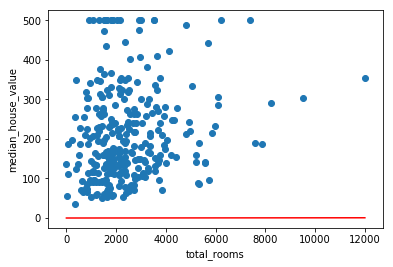

In [15]:
#将数据和学到的线可视化。我们已经知道，单个特征的线性回归可绘制成一条将输入 x 映射到输出 y 的线。
sample = california_housing_dataframe.sample(n=300)
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

In [18]:
#将上述所有代码放入一个函数中。您可以使用不同的参数调用该函数，以了解相应效果。
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)
  plt.show()

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 236.32
  period 01 : 235.11
  period 02 : 233.90
  period 03 : 232.70
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13
  period 07 : 227.96
  period 08 : 226.79
  period 09 : 225.63
Model training finished.


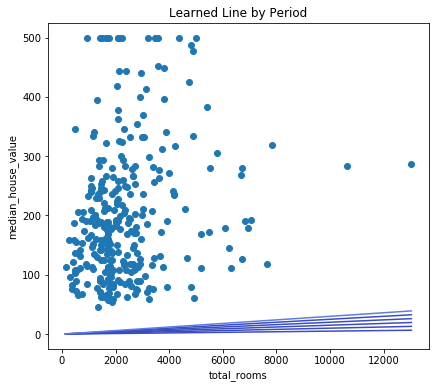

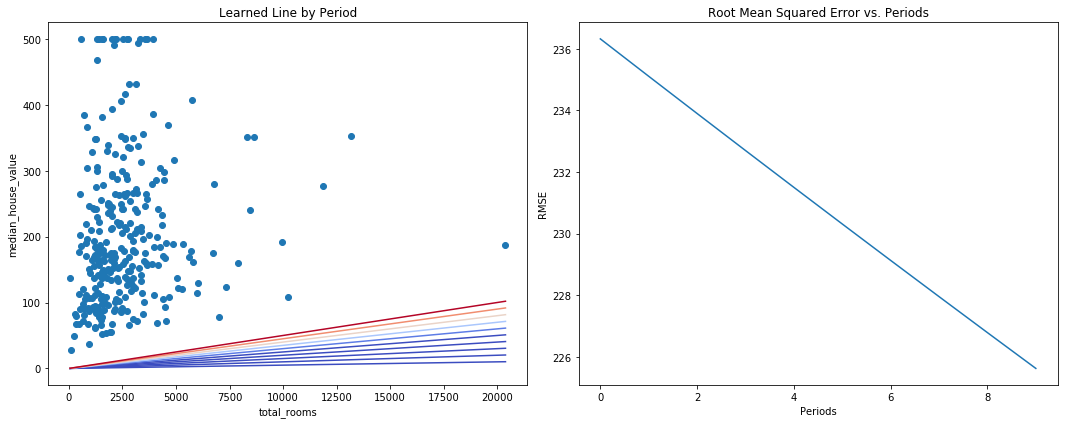

,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 225.63


In [19]:
#调整模型超参数，使 RMSE 不超过 180。
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

Training model...
RMSE (on training data):
  period 00 : 214.42
  period 01 : 194.62
  period 02 : 181.89
  period 03 : 173.57
  period 04 : 169.46
  period 05 : 167.02
  period 06 : 166.32
  period 07 : 167.02
  period 08 : 169.47
  period 09 : 170.16
Model training finished.


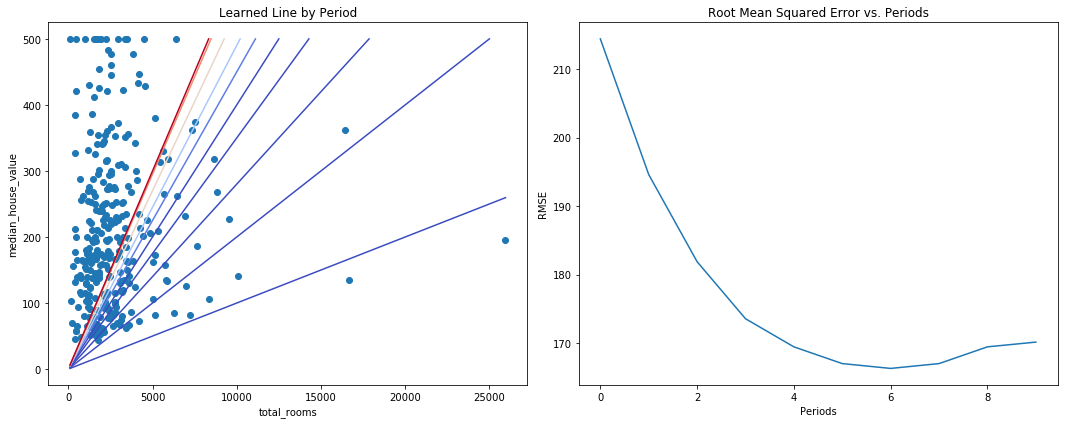

,predictions,targets
count,17000.0,17000.0
mean,158.6,207.3
std,130.8,116.0
min,0.1,15.0
25%,87.7,119.4
50%,127.6,180.4
75%,189.1,265.0
max,2276.2,500.0


Final RMSE (on training data): 170.16


In [20]:
train_model(
    learning_rate=0.0001,
    steps=200,
    batch_size=1
)

In [ ]:
# 训练误差应该稳步减小，刚开始是急剧减小，最终应随着训练收敛达到平稳状态。
# 如果训练尚未收敛，尝试运行更长的时间。
# 如果训练误差减小速度过慢，则提高学习速率也许有助于加快其减小速度。
# 但有时如果学习速率过高，训练误差的减小速度反而会变慢。
# 如果训练误差变化很大，尝试降低学习速率。
# 较低的学习速率和较大的步数/较大的批量大小通常是不错的组合。
# 批量大小过小也会导致不稳定情况。不妨先尝试 100 或 1000 等较大的值，然后逐渐减小值的大小，直到出现性能降低的情况。